<a href="https://colab.research.google.com/github/griisnc/Data_Engineering_Analysis_BI/blob/main/Analysis_BI_GriisNavarrete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manufacturing Production and Maintenance Analysis

This project analyzes simulated data from a manufacturing environment to understand the impact of production and maintenance activities on costs and downtime. The analysis focuses on identifying key failure types contributing to expenses and production stops, providing insights for optimizing maintenance strategies and improving overall efficiency.

***Created by: Griselda Navarrete***

This data analysis is focused on understanding the production and maintenance activities within a simulated manufacturing environment. The goal is to identify key factors contributing to costs and downtime, ultimately aiming to improve efficiency and reduce expenses.

Here's a breakdown of the situation based on the analysis performed:

* Data: The analysis uses simulated data representing production and maintenance records over approximately one year. This data includes information about production lines, maintenance types, failure types, downtime, costs (material, labor, and total), units produced, responsible parties, and priority levels.
* Analysis Steps: The notebook follows a typical data analysis workflow:
Data Generation: Creating the synthetic dataset for analysis.
Data Extraction and Exploration: Loading the data and understanding its structure, content, and basic statistics, including identifying unique categories and visualizing initial relationships (like cost by maintenance type and downtime by production line).
  - Data Transformation: Cleaning the data by handling missing values and outliers, calculating key maintenance metrics like MTBF and MTTR, and categorizing costs.
  - Business Intelligence Analysis: Aggregating data to understand trends and performance at a monthly and production line level. A Pareto analysis is conducted specifically on failure types to pinpoint the most impactful ones in terms of cost and downtime.

* Key Insights from the Analysis (based on the outputs):
  - The dataset contains 2000 records spanning from June 2024 to June 2025.
  - There are three production lines (Línea A, Línea B, Línea C), three maintenance types (Predictivo, Correctivo, Preventivo), and six failure types (including 'Sin falla').
  - The descriptive statistics provide an overview of the distribution of numerical data like costs, downtime, and units produced.
  - The Pareto analysis clearly shows that a few failure types (Eléctrica, Software, Hidráulica, Neumática, and Mecánica) account for the majority of the total cost and downtime. This is a key finding for prioritizing improvement efforts.




In essence, the analysis provides a foundation for understanding maintenance performance, identifying problematic areas (specifically failure types with the highest impact), and can be used to inform strategies for reducing costs and improving production uptime.

# Librerías

In [61]:
# Import necessary libraries
import pandas as pd
import numpy as np
import pyodbc # This library is for database connections, but not used in the current code
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'pyodbc'

# 1. Generar datos

In [62]:
# Initial configuration for data generation
np.random.seed(42) # Set seed for reproducibility of random numbers
random.seed() # Initialize the random number generator
num_registros = 2000 # Number of records to generate
lineas_produccion = ['Línea A', 'Línea B', 'Línea C'] # List of production lines
tipos_falla = ['Mecánica', 'Eléctrica', 'Neumática', 'Hidráulica', 'Software', 'Sin falla'] # List of failure types
turnos = ['Mañana', 'Tarde', 'Noche'] # List of shifts
responsables = ['Operador', 'Técnico', 'Supervisor', 'Externo'] # List of responsible parties

In [63]:
# Generate random dates for the records within the last year
fechas = [datetime.now() - timedelta(days=random.randint(1, 365)) for _ in range(num_registros)]
fechas.sort() # Sort the dates chronologically

In [64]:
# Create a dictionary to hold the simulated data
data = {
    'Fecha': fechas, # Generated dates
    'Linea_Produccion': [random.choice(lineas_produccion) for _ in range(num_registros)], # Randomly select production line
    'Turno': [random.choice(turnos) for _ in range(num_registros)], # Randomly select shift
    'Orden_Trabajo': [f"OT-{random.randint(2000, 9999)}" for _ in range(num_registros)], # Generate unique work order IDs
    'Tipo_Mantenimiento': [random.choice(['Preventivo', 'Correctivo', 'Predictivo']) for _ in range(num_registros)], # Randomly select maintenance type
    'Tipo_Falla': [random.choice(tipos_falla) for _ in range(num_registros)], # Randomly select failure type
    'Tiempo_Parada_Min': np.random.lognormal(mean=3, sigma=1, size=num_registros).round(2), # Generate downtime in minutes using a lognormal distribution
    'Costo_Material': np.random.lognormal(mean=5, sigma=1, size=num_registros).round(2), # Generate material cost using a lognormal distribution
    'Costo_Mano_Obra': np.random.lognormal(mean=6, sigma=1, size=num_registros).round(2), # Generate labor cost using a lognormal distribution
    'Unidades_Producidas': np.random.randint(50, 500, size=num_registros), # Generate random number of units produced
    'Responsable': [random.choice(responsables) for _ in range(num_registros)], # Randomly select responsible party
    'Prioridad': [random.choice(['Alta', 'Media', 'Baja']) for _ in range(num_registros)] # Randomly select priority level
}

In [65]:
# Convert the data dictionary into a Pandas DataFrame
df = pd.DataFrame(data)

In [66]:
# Calculate derived fields and ensure correct data types
df['Costo_Total'] = df['Costo_Material'] + df['Costo_Mano_Obra'] # Calculate total cost
df['Costo_por_Unidad'] = df['Costo_Total'] / df['Unidades_Producidas'] # Calculate cost per unit
df['Fecha'] = pd.to_datetime(df['Fecha']) # Convert 'Fecha' column to datetime objects
df['Mes'] = df['Fecha'].dt.month_name() # Extract month name
df['Semana'] = df['Fecha'].dt.isocalendar().week # Extract week number
df['Dia_Semana'] = df['Fecha'].dt.day_name() # Extract day of the week name

In [67]:
# Print a message indicating that the simulated data has been generated
print("Datos simulados generados y guardados en 'datos_produccion_mantenimiento.csv'")

Datos simulados generados y guardados en 'datos_produccion_mantenimiento.csv'


In [68]:
# This cell was commented out and is not currently used for saving the data.
# df.to_csv('C:/Users/grise/OneDrive/Imágenes/2025/junio/LEGO/datos_produccion_mantenimiento.csv', index=False)

In [69]:
# Display the first 5 rows of the DataFrame to preview the data
df.head(5)

,Fecha,Linea_Produccion,Turno,Orden_Trabajo,Tipo_Mantenimiento,Tipo_Falla,Tiempo_Parada_Min,Costo_Material,Costo_Mano_Obra,Unidades_Producidas,Responsable,Prioridad,Costo_Total,Costo_por_Unidad,Mes,Semana,Dia_Semana
0,2024-06-24 01:08:57.841569,Línea A,Mañana,OT-6077,Correctivo,Software,33.01,75.55,170.12,87,Operador,Alta,245.67,2.823793,June,26,Monday
1,2024-06-24 01:08:57.841765,Línea A,Tarde,OT-6887,Correctivo,Sin falla,17.49,128.44,391.03,474,Supervisor,Alta,519.47,1.095928,June,26,Monday
2,2024-06-24 01:08:57.841949,Línea B,Mañana,OT-7058,Correctivo,Software,38.39,67.19,410.76,184,Operador,Media,477.95,2.597554,June,26,Monday
3,2024-06-24 01:08:57.842317,Línea C,Noche,OT-3465,Preventivo,Hidráulica,92.11,109.08,647.18,383,Supervisor,Baja,756.26,1.974569,June,26,Monday
4,2024-06-24 01:08:57.842553,Línea B,Mañana,OT-2378,Preventivo,Mecánica,15.89,22.34,102.84,284,Externo,Media,125.18,0.440775,June,26,Monday


# 2. Extracción de Datos

In [70]:
# Configure display options for Pandas and set seaborn style
pd.set_option('display.max_columns', None) # Display all columns
warnings.filterwarnings('ignore') # Ignore warnings
sns.set_style('whitegrid') # Set the style for seaborn plots

In [71]:
# Load data from a CSV file and perform initial checks
try:
    # Attempt to read the CSV file, parsing 'Fecha' as dates
    df = pd.read_csv('C:/Users/grise/OneDrive/Imágenes/2025/junio/LEGO/datos_produccion_mantenimiento.csv', parse_dates=['Fecha'])
    print(" Datos cargados correctamente") # Print success message
    print(f" Total de registros: {len(df):,}") # Print total number of records
    print(f" Rango de fechas: {df['Fecha'].min().date()} a {df['Fecha'].max().date()}") # Print the date range
except Exception as e:
    print(f" Error al cargar datos: {e}") # Print error message if loading fails

 Error al cargar datos: [Errno 2] No such file or directory: 'C:/Users/grise/OneDrive/Imágenes/2025/junio/LEGO/datos_produccion_mantenimiento.csv'


In [72]:
# Print the structure and data types of the DataFrame
print(" Estructura del dataset:")
df.info()

 Estructura del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Fecha                2000 non-null   datetime64[ns]
 1   Linea_Produccion     2000 non-null   object        
 2   Turno                2000 non-null   object        
 3   Orden_Trabajo        2000 non-null   object        
 4   Tipo_Mantenimiento   2000 non-null   object        
 5   Tipo_Falla           2000 non-null   object        
 6   Tiempo_Parada_Min    2000 non-null   float64       
 7   Costo_Material       2000 non-null   float64       
 8   Costo_Mano_Obra      2000 non-null   float64       
 9   Unidades_Producidas  2000 non-null   int64         
 10  Responsable          2000 non-null   object        
 11  Prioridad            2000 non-null   object        
 12  Costo_Total          2000 non-null   float64       
 13  Costo_po

In [73]:
# Print descriptive statistics for all columns in the DataFrame, rounded to 2 decimal places
print("Estadísticas descriptivas:")
df.describe(include='all').round(2)

Estadísticas descriptivas:


,Fecha,Linea_Produccion,Turno,Orden_Trabajo,Tipo_Mantenimiento,Tipo_Falla,Tiempo_Parada_Min,Costo_Material,Costo_Mano_Obra,Unidades_Producidas,Responsable,Prioridad,Costo_Total,Costo_por_Unidad,Mes,Semana,Dia_Semana
count,2000,2000,2000,2000,2000,2000,2000.00,2000.00,2000.00,2000.00,2000,2000,2000.00,2000.00,2000,2000.0,2000
unique,NaN,3,3,1743,3,6,NaN,NaN,NaN,NaN,4,3,NaN,NaN,12,<NA>,7
top,NaN,Línea A,Mañana,OT-3808,Preventivo,Hidráulica,NaN,NaN,NaN,NaN,Externo,Alta,NaN,NaN,August,<NA>,Saturday
freq,NaN,686,695,4,712,361,NaN,NaN,NaN,NaN,522,683,NaN,NaN,177,<NA>,331
mean,2024-12-24 02:21:41.042752256,NaN,NaN,NaN,NaN,NaN,34.48,245.70,632.98,273.39,NaN,NaN,878.68,4.42,NaN,26.75,NaN
min,2024-06-24 01:08:57.841569,NaN,NaN,NaN,NaN,NaN,0.79,7.25,16.83,50.00,NaN,NaN,58.56,0.16,NaN,1.0,NaN
25%,2024-09-22 01:08:57.843661824,NaN,NaN,NaN,NaN,NaN,10.78,73.03,203.00,160.00,NaN,NaN,369.11,1.39,NaN,14.0,NaN
50%,2024-12-21 13:08:57.842761216,NaN,NaN,NaN,NaN,NaN,21.00,148.40,391.42,276.00,NaN,NaN,627.18,2.57,NaN,27.0,NaN
75%,2025-03-27 01:08:57.842051584,NaN,NaN,NaN,NaN,NaN,39.76,288.74,756.59,382.25,NaN,NaN,1083.84,5.22,NaN,40.0,NaN
max,2025-06-23 01:08:57.843821,NaN,NaN,NaN,NaN,NaN,946.46,7526.89,9071.66,499.00,NaN,NaN,9114.53,80.51,NaN,52.0,NaN


In [74]:
# Print unique values for key categorical columns
print(f"Lineas de Producción: ", df.Linea_Produccion.unique())
print(f"Tipo de Mantenimiento: ", df.Tipo_Mantenimiento.unique())
print(f"Tipo de Fallas", df.Tipo_Falla.unique())

Lineas de Producción:  ['Línea A' 'Línea B' 'Línea C']
Tipo de Mantenimiento:  ['Correctivo' 'Preventivo' 'Predictivo']
Tipo de Fallas ['Software' 'Sin falla' 'Hidráulica' 'Mecánica' 'Eléctrica' 'Neumática']


## Visualización de distribuciones

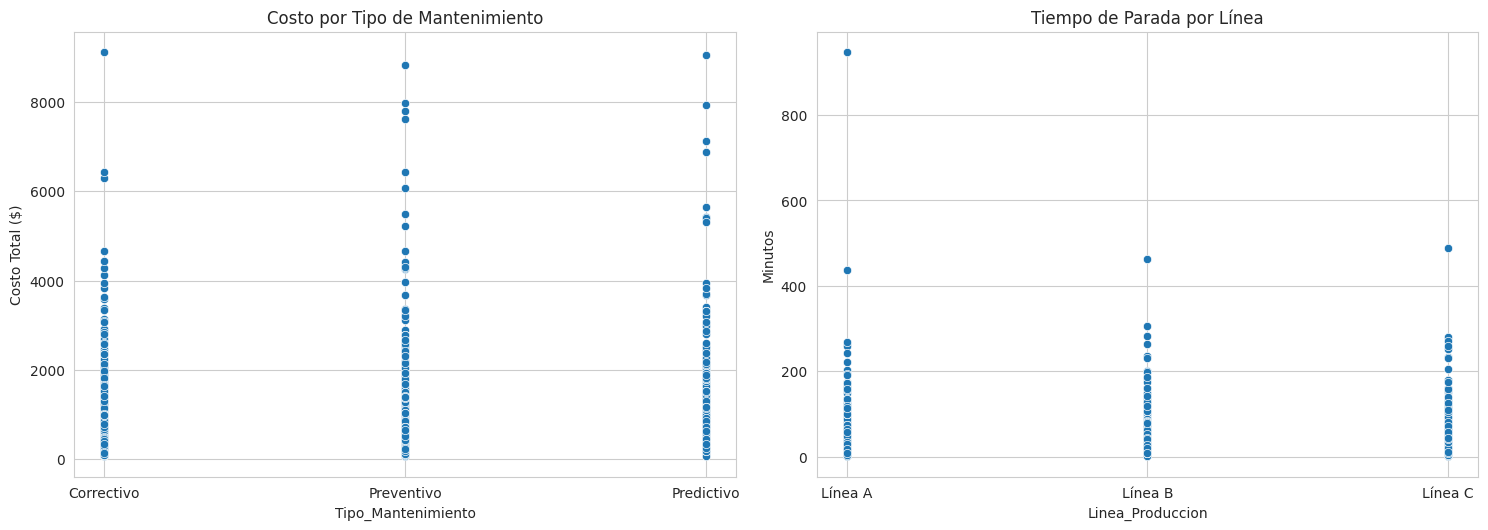

In [75]:
# Visualize distributions using scatter plots
plt.figure(figsize=(15, 10)) # Set the figure size

# Scatter plot for Costo Total by Tipo de Mantenimiento
plt.subplot(2, 2, 3) # Create a subplot
sns.scatterplot(data=df, x='Tipo_Mantenimiento', y='Costo_Total') # Create the scatter plot
plt.title('Costo por Tipo de Mantenimiento') # Set the title
plt.ylabel('Costo Total ($)') # Set the y-axis label

# Scatter plot for Tiempo de Parada Min by Linea de Produccion
plt.subplot(2, 2, 4) # Create another subplot
sns.scatterplot(data=df, x='Linea_Produccion', y='Tiempo_Parada_Min') # Create the scatter plot
plt.title('Tiempo de Parada por Línea') # Set the title
plt.ylabel('Minutos') # Set the y-axis label

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show() # Display the plots

# 3. Transformación de Datos

In [76]:
# Clean the data by dropping rows with missing values in specified columns
df_clean = df.dropna(subset=['Linea_Produccion', 'Tipo_Mantenimiento', 'Costo_Total'])

In [77]:
# Validate and correct data formats for specific columns
df_clean['Fecha'] = pd.to_datetime(df_clean['Fecha']) # Ensure 'Fecha' is datetime
df_clean['Orden_Trabajo'] = df_clean['Orden_Trabajo'].astype(str) # Ensure 'Orden_Trabajo' is string

In [78]:
# Filter out outliers in 'Costo_Total' based on quantiles (optional)
q1 = df_clean['Costo_Total'].quantile(0.05) # Calculate the 5th percentile
q3 = df_clean['Costo_Total'].quantile(0.95) # Calculate the 95th percentile
df_clean = df_clean[(df_clean['Costo_Total'] >= q1) & (df_clean['Costo_Total'] <= q3)] # Filter the DataFrame

In [79]:
# Print the number of records remaining after cleaning and the percentage reduction
print(f" Registros después de limpieza: {len(df_clean):,} ({(len(df)-len(df_clean))/len(df):.1%} reducción)")

 Registros después de limpieza: 1,800 (10.0% reducción)


In [80]:
# Display the first 5 rows of the cleaned DataFrame
df_clean.head(5)

,Fecha,Linea_Produccion,Turno,Orden_Trabajo,Tipo_Mantenimiento,Tipo_Falla,Tiempo_Parada_Min,Costo_Material,Costo_Mano_Obra,Unidades_Producidas,Responsable,Prioridad,Costo_Total,Costo_por_Unidad,Mes,Semana,Dia_Semana
0,2024-06-24 01:08:57.841569,Línea A,Mañana,OT-6077,Correctivo,Software,33.01,75.55,170.12,87,Operador,Alta,245.67,2.823793,June,26,Monday
1,2024-06-24 01:08:57.841765,Línea A,Tarde,OT-6887,Correctivo,Sin falla,17.49,128.44,391.03,474,Supervisor,Alta,519.47,1.095928,June,26,Monday
2,2024-06-24 01:08:57.841949,Línea B,Mañana,OT-7058,Correctivo,Software,38.39,67.19,410.76,184,Operador,Media,477.95,2.597554,June,26,Monday
3,2024-06-24 01:08:57.842317,Línea C,Noche,OT-3465,Preventivo,Hidráulica,92.11,109.08,647.18,383,Supervisor,Baja,756.26,1.974569,June,26,Monday
5,2024-06-24 01:08:57.843790,Línea C,Noche,OT-6478,Correctivo,Eléctrica,15.89,183.70,729.65,486,Técnico,Media,913.35,1.879321,June,26,Monday


## Cálculo de KPIs

In [81]:
# Calculate Time Between Failures (for MTBF calculation)
# Sort data by production line and date
df_sorted = df_clean.sort_values(['Linea_Produccion', 'Fecha'])
# Calculate the time difference between consecutive failures for each production line in minutes
df_sorted['Tiempo_Entre_Fallas'] = df_sorted.groupby('Linea_Produccion')['Fecha'].diff().dt.total_seconds() / 60

In [82]:
# Calculate MTBF (Mean Time Between Failures) per production line
# Group by production line and calculate the mean of 'Tiempo_Entre_Fallas'
mtbf = df_sorted.groupby('Linea_Produccion')['Tiempo_Entre_Fallas'].mean().round(2)
# Map the calculated MTBF back to the cleaned DataFrame
df_clean['MTBF'] = df_clean['Linea_Produccion'].map(mtbf)

In [83]:
# Calculate MTTR (Mean Time To Repair) per production line
# Group by production line and calculate the mean of 'Tiempo_Parada_Min'
mttr = df_clean.groupby('Linea_Produccion')['Tiempo_Parada_Min'].mean().round(2)
# Map the calculated MTTR back to the cleaned DataFrame
df_clean['MTTR'] = df_clean['Linea_Produccion'].map(mttr)

## Clasificación de costos

In [84]:
# Classify total cost into categories (Bajo, Medio, Alto)
conditions = [
    (df_clean['Costo_Total'] < 500), # Condition for 'Bajo' cost
    (df_clean['Costo_Total'] >= 500) & (df_clean['Costo_Total'] < 2000), # Condition for 'Medio' cost
    (df_clean['Costo_Total'] >= 2000) # Condition for 'Alto' cost
]
categories = ['Bajo', 'Medio', 'Alto'] # List of cost categories
# Apply the conditions to create the 'Nivel_Costo' column
df_clean['Nivel_Costo'] = np.select(conditions, categories, default='Medio')

## Campos derivados adicionales

In [85]:
# Add additional derived date-related fields
df_clean['Mes'] = df_clean['Fecha'].dt.month_name() # Extract month name
df_clean['Num_Mes']=df_clean['Fecha'].dt.month # Extract month number
df_clean['Semana'] = df_clean['Fecha'].dt.isocalendar().week # Extract week number
df_clean['Dia_Semana'] = df_clean['Fecha'].dt.day_name() # Extract day of the week name
df_clean['Anio'] = df_clean['Fecha'].dt.year # Extract year
df_clean['Costo_por_Unidad'] = df_clean['Costo_Total'] / df_clean['Unidades_Producidas'] # Recalculate cost per unit

In [86]:
# Verify the transformed data by displaying a random sample of 5 rows with key columns
print(" Verificación de datos transformados:")
df_clean[['Linea_Produccion', 'MTBF', 'MTTR', 'Nivel_Costo', 'Costo_por_Unidad']].sample(5).round(3)

 Verificación de datos transformados:


,Linea_Produccion,MTBF,MTTR,Nivel_Costo,Costo_por_Unidad
1441,Línea A,846.79,36.53,Bajo,0.978
1227,Línea A,846.79,36.53,Medio,5.204
161,Línea C,905.28,33.37,Medio,3.275
1674,Línea A,846.79,36.53,Bajo,0.758
615,Línea B,875.06,33.52,Medio,1.926


# 4. Análisis para Business Intelligence

In [87]:
# Summarize data monthly by production line for business intelligence
resumen_mensual = df_clean.groupby(['Anio', 'Num_Mes','Mes', 'Linea_Produccion']).agg({
    'Costo_Total': ['sum', 'mean'], # Calculate sum and mean of total cost
    'Tiempo_Parada_Min': ['sum', 'mean'], # Calculate sum and mean of downtime
    'Unidades_Producidas': 'sum', # Calculate sum of units produced
    'MTBF': 'mean', # Calculate mean MTBF
    'MTTR': 'mean' # Calculate mean MTTR
}).round(2)

In [88]:
# Flatten the multi-level column names and reset the index
resumen_mensual.columns = ['_'.join(col).strip() for col in resumen_mensual.columns.values] # Join column names
resumen_mensual = resumen_mensual.reset_index() # Reset index to make grouped columns regular columns
# Calculate Cost per Unit for the monthly summary
resumen_mensual['Costo_por_Unidad'] = resumen_mensual['Costo_Total_sum'] / resumen_mensual['Unidades_Producidas_sum']

In [89]:
# Print the monthly summary sorted by year and month
print("Resumen Mensual por Línea:")
display(resumen_mensual.sort_values(by=['Anio','Num_Mes'],ascending=True))

Resumen Mensual por Línea:


,Anio,Num_Mes,Mes,Linea_Produccion,Costo_Total_sum,Costo_Total_mean,Tiempo_Parada_Min_sum,Tiempo_Parada_Min_mean,Unidades_Producidas_sum,MTBF_mean,MTTR_mean,Costo_por_Unidad
0,2024,6,June,Línea A,3388.26,376.47,164.92,18.32,2214,846.79,36.53,1.530379
1,2024,6,June,Línea B,6622.47,662.25,227.69,22.77,2882,875.06,33.52,2.297873
2,2024,6,June,Línea C,9404.52,854.96,220.22,20.02,3096,905.28,33.37,3.037636
3,2024,7,July,Línea A,33241.13,810.76,1170.30,28.54,10618,846.79,36.53,3.130639
4,2024,7,July,Línea B,34511.37,704.31,1689.96,34.49,13638,875.06,33.52,2.530530
5,2024,7,July,Línea C,40057.04,715.30,1655.55,29.56,13740,905.28,33.37,2.915360
6,2024,8,August,Línea A,42378.21,718.27,2945.08,49.92,16086,846.79,36.53,2.634478
7,2024,8,August,Línea B,29514.65,776.70,1069.93,28.16,10309,875.06,33.52,2.862998
8,2024,8,August,Línea C,42681.70,748.80,1548.81,27.17,16085,905.28,33.37,2.653509
9,2024,9,September,Línea A,36682.27,780.47,1777.22,37.81,13392,846.79,36.53,2.739118


# Análisis de Pareto para tipos de falla

In [90]:
# Perform Pareto analysis for failure types (excluding 'Sin falla')
pareto_fallas = df_clean[df_clean['Tipo_Falla'] != 'Sin falla'].groupby('Tipo_Falla').agg({
    'Costo_Total': 'sum', # Calculate the sum of total cost
    'Tiempo_Parada_Min': 'sum', # Calculate the sum of downtime
    'Orden_Trabajo': 'count' # Count the number of work orders (occurrences)
}).sort_values('Costo_Total', ascending=False) # Sort by total cost in descending order

In [91]:
# Calculate the cumulative percentage for the Pareto analysis based on total cost
pareto_fallas['Porcentaje_Acumulado'] = (pareto_fallas['Costo_Total'].cumsum() / pareto_fallas['Costo_Total'].sum() * 100).round(2)

In [92]:
# Print the Pareto analysis results
print("📊 Análisis de Pareto para Tipos de Falla:")
display(pareto_fallas.sort_values(by='Costo_Total',ascending=False))

📊 Análisis de Pareto para Tipos de Falla:


,Costo_Total,Tiempo_Parada_Min,Orden_Trabajo,Porcentaje_Acumulado
Tipo_Falla,,,,
Hidráulica,249354.63,10035.86,320,21.81
Software,241099.13,10003.51,313,42.90
Mecánica,230313.03,11890.18,299,63.05
Eléctrica,213520.15,10205.81,290,81.73
Neumática,208867.56,9250.20,278,100.00


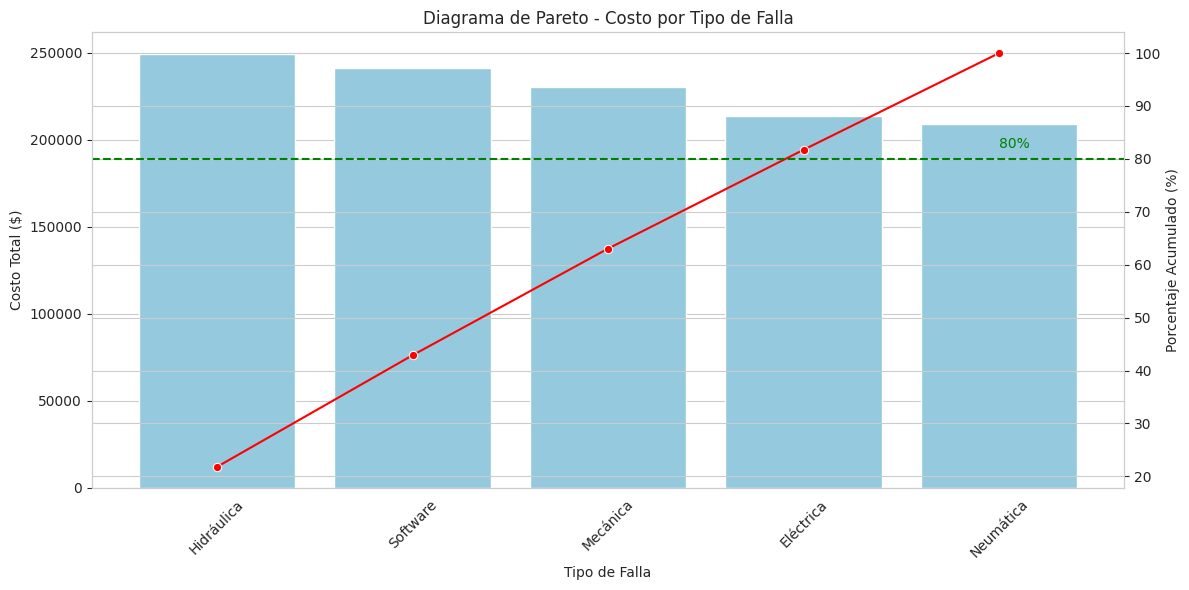

In [93]:
# Visualize the Pareto chart for cost by failure type
plt.figure(figsize=(12, 6)) # Set the figure size

# Create a bar plot for the total cost by failure type
ax1 = sns.barplot(x=pareto_fallas.index, y=pareto_fallas['Costo_Total'], color='skyblue')
plt.ylabel('Costo Total ($)') # Set the y-axis label for the bar plot
plt.xlabel('Tipo de Falla') # Set the x-axis label
plt.xticks(rotation=45) # Rotate x-axis labels for better readability

# Create a twin axis for the cumulative percentage line plot
ax2 = plt.twinx()
# Create a line plot for the cumulative percentage
sns.lineplot(x=pareto_fallas.index, y=pareto_fallas['Porcentaje_Acumulado'],color='red', marker='o', ax=ax2)
ax2.set_ylabel('Porcentaje Acumulado (%)') # Set the y-axis label for the line plot
ax2.axhline(80, color='green', linestyle='--') # Add a horizontal line at 80%
ax2.text(len(pareto_fallas)-1, 82, '80%', color='green') # Add text label for the 80% line

plt.title('Diagrama de Pareto - Costo por Tipo de Falla') # Set the title of the plot
plt.tight_layout() # Adjust layout
plt.show() # Display the plot